# Самостоятельный проект: 

Анализ рынка заведений общественного питания Москвы
---

Планируется открытие кафе в Москве. Фишкой заведения будет обслуживание постетителей роботами. Необходимо подготовить анализ рынка общественного питания для предполагаемых инвесторов. 

---
*Цель проекта:* Подготовить исследование рынка заведений общественного питания города Москвы.

---

**Необходимые данные:**

rest_data - таблица заведений общественного питания Москвы:

    id — идентификатор объекта;
    object_name — название объекта общественного питания;
    chain — сетевой ресторан;
    object_type — тип объекта общественного питания;
    address — адрес;
    number — количество посадочных мест
 
Ссылка на презентацию: https://disk.yandex.ru/i/JkMW75qzIZHzbg

## Предобработка данных

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import json
from mapbox import Geocoder
import re
import folium
import requests
from urllib.parse import urlencode
import sys
from io import StringIO

In [2]:
rest_data_url = #ссылка
dist_url = #ссылка


def read_from_yandex_disk(public_key):
    base_url = #ссылка
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    data = StringIO(download_response.content.decode("utf-8"))
    return pd.read_csv(data, sep=",")

rest_data = read_from_yandex_disk(rest_data_url)

In [3]:
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [4]:
rest_data.isnull().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

In [5]:
rest_data.duplicated().sum()

0

In [6]:
def number_category(row):
 
    if row['number'] <= 20:
        return 'от 0 до 20'
    if row['number'] <= 60:
        return 'от 20 до 60'
    if row['number'] <= 100:
        return 'от 60 до 100'
    if row['number'] <= 150:
        return 'от 100 до 150'
    if row['number'] <= 200:
        return 'от 150 до 200'
    if row['number'] <= 300:
        return 'от 200 до 300'
    if row['number'] <= 400:
        return 'от 300 до 400'
    if row['number'] <= 500:
        return 'от 400 до 500'
    return 'больше 500'
 
rest_data['number_category'] = rest_data.apply(number_category, axis = 1)
rest_data.head()

,id,object_name,chain,object_type,address,number,number_category
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,от 20 до 60
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,от 20 до 60
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,от 60 до 100
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,от 20 до 60
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,от 20 до 60


---
- Подготовила данные к анализу, проверила на наличие пропусков и дубликатов, а так же на некоректность типов данных
- Категоризировала количество посадочных мест

---

## Анализ данных

### Типы объектов общественного питания

In [7]:
count_objects_type = rest_data.groupby('object_type')['id'].count().to_frame().sort_values('id', ascending=False)
count_objects_type.columns = ['count']
count_objects_type

,count
object_type,
кафе,6099
столовая,2587
ресторан,2285
предприятие быстрого обслуживания,1923
бар,856
буфет,585
кафетерий,398
закусочная,360
магазин (отдел кулинарии),273


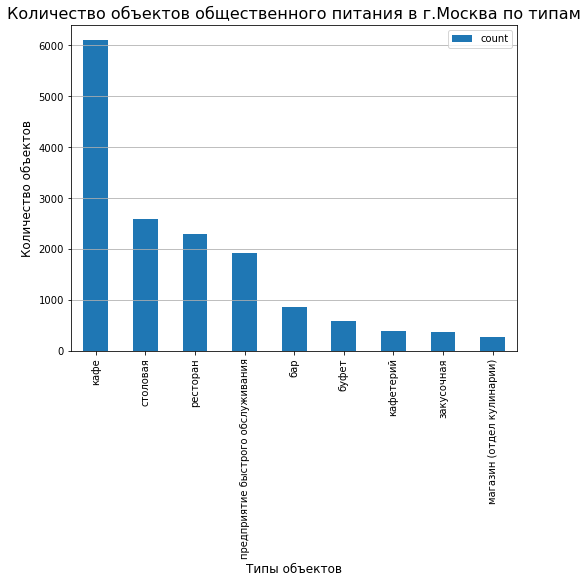

In [8]:
count_objects_type.plot(kind='bar', figsize = (8,6))
plt.xlabel('Типы объектов',fontsize=12)
plt.ylabel('Количество объектов',fontsize=12)
plt.title('Количество объектов общественного питания в г.Москва по типам', fontsize=16)
plt.grid(True, axis='y')
plt.show()

---
- По количеству типов объектов общественного питания лидирует "кафе", их больше 6 тысяч в Москве. Далее по списку "столовая" и "ресторан", их больше 2 тысяч.
- Самым непопулярным типом является "магазин (отдел кулинарии)", всего 273.

---

In [9]:
rest_data['chain'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

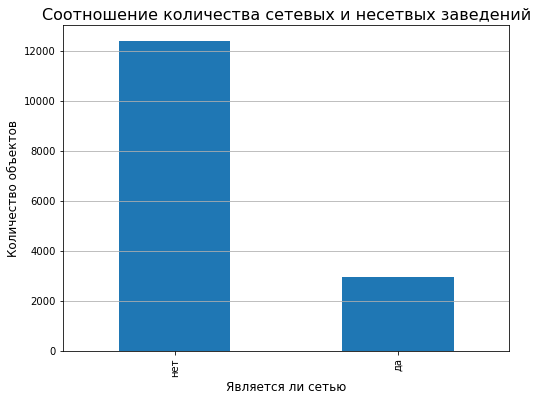

In [10]:
rest_data['chain'].value_counts().plot(kind='bar', figsize = (8,6))
plt.xlabel('Является ли сетью',fontsize=12)
plt.ylabel('Количество объектов',fontsize=12)
plt.title('Соотношение количества сетевых и несетвых заведений', fontsize=16)
plt.grid(True, axis='y')
plt.show()

---
Несетевых заведений значительно больше, чем сетевых.

---

## Связь между типами объектов общественного питания и причастностью к сети

In [11]:
rest_in_chain = rest_data[rest_data['chain'] == 'да']
rest_in_chain_count = rest_in_chain.groupby('object_type')['id'].count().to_frame().reset_index()
rest_in_chain_count.columns = ['type' ,'count']
rest_in_chain_count.head()

,type,count
0,бар,37
1,буфет,11
2,закусочная,56
3,кафе,1396
4,кафетерий,52


In [12]:
rest_not_in_chain = rest_data[rest_data['chain'] == 'нет']
rest_not_in_chain_count = rest_not_in_chain.groupby('object_type')['id'].count().to_frame().reset_index()
rest_not_in_chain_count.columns = ['type' ,'count']
rest_not_in_chain_count.head()

,type,count
0,бар,819
1,буфет,574
2,закусочная,304
3,кафе,4703
4,кафетерий,346


In [13]:
rests_chain_count = rest_not_in_chain_count.merge(rest_in_chain_count, on='type')
rests_chain_count = rests_chain_count.set_index('type').sort_values('count_y', ascending=False)
rests_chain_count.columns = ['not_in_chain', 'in_chain']
rests_chain_count

,not_in_chain,in_chain
type,,
кафе,4703,1396
предприятие быстрого обслуживания,1132,791
ресторан,1741,544
магазин (отдел кулинарии),195,78
закусочная,304,56
кафетерий,346,52
бар,819,37
буфет,574,11
столовая,2584,3


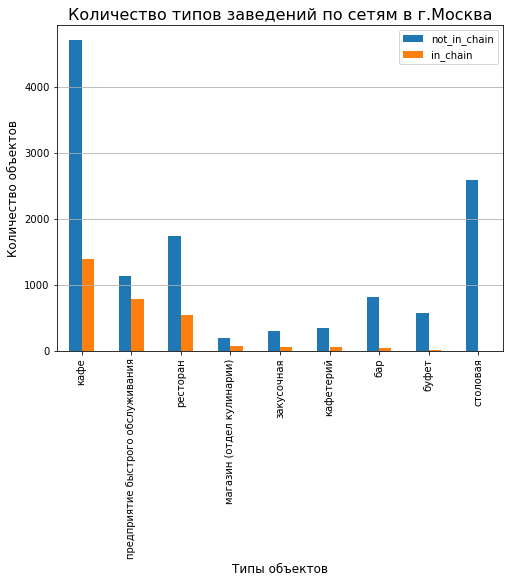

In [14]:
rests_chain_count.plot(kind='bar', figsize = (8,6))
plt.xlabel('Типы объектов',fontsize=12)
plt.ylabel('Количество объектов',fontsize=12)
plt.title('Количество типов заведений по сетям в г.Москва', fontsize=16)
plt.grid(True, axis='y')
plt.show()

---
- В сетях заведений общественного питания приобладают 3 типа заведений: "кафе", "предприятие быстрого обслуживания", "ресторан".
- У заведений, не относящихся к сетям, лидирующие позиции занимают: "кафе", "столовая", "ресторан".

---

## Особенности сетевых заведений общественного питания

In [15]:
rest_in_chain.head()

,id,object_name,chain,object_type,address,number,number_category
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,от 20 до 60
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10,от 0 до 20
13,22579,Алло Пицца,да,кафе,"город Москва, улица Авиаторов, дом 14",32,от 20 до 60
16,144107,Суши Wok,да,предприятие быстрого обслуживания,"город Москва, Азовская улица, дом 3",7,от 0 до 20
18,58565,Тануки,да,ресторан,"город Москва, Большая Академическая улица, дом 65",160,от 150 до 200


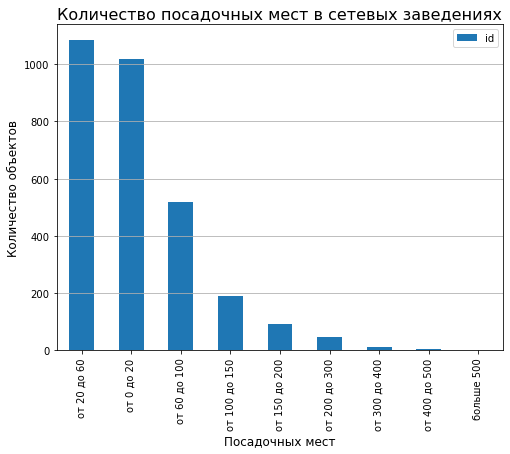

In [16]:
rest_in_chain.groupby('number_category')['id'].count().to_frame().sort_values('id', ascending=False).plot(kind='bar', figsize = (8,6))
plt.xlabel('Посадочных мест',fontsize=12)
plt.ylabel('Количество объектов',fontsize=12)
plt.title('Количество посадочных мест в сетевых заведениях', fontsize=16)
plt.grid(True, axis='y')
plt.show()

---
- Среди сетевых заведений больше всего распространены заведения с количеством посадочных мест от 20 до 60
- На втором месте по популярности заведения, в которых до 20 посадочных мест
- Заведения на 100 посадочных мест и больше самые непопулярные среди сетевых

---

## Среднее количество посадочных мест

In [17]:
rest_data.head()

,id,object_name,chain,object_type,address,number,number_category
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,от 20 до 60
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,от 20 до 60
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,от 60 до 100
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,от 20 до 60
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,от 20 до 60


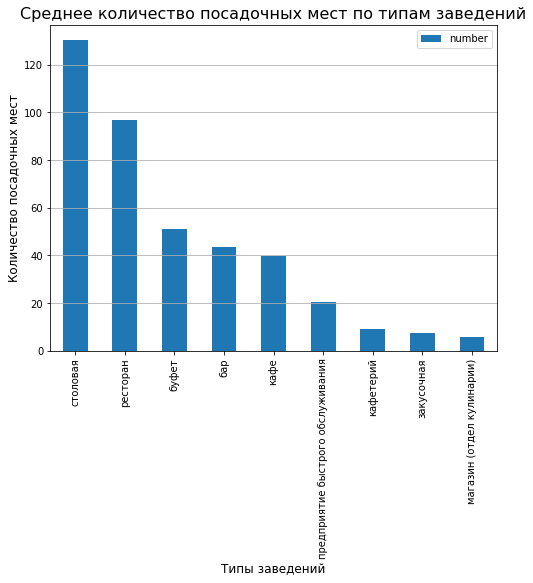

In [18]:
rest_data.groupby('object_type')['number'].mean().to_frame().sort_values('number', ascending=False).plot(kind='bar', figsize = (8,6))
plt.xlabel('Типы заведений',fontsize=12)
plt.ylabel('Количество посадочных мест',fontsize=12)
plt.title('Среднее количество посадочных мест по типам заведений', fontsize=16)
plt.grid(True, axis='y')
plt.show()

---
- Самое большое среденее количество посадочных мест в заведениях с типом "столовая" и "ресторан"
- Заведения с типом "предприятие быстрого обслуживания", "кафетерий", "закусочная" и "магазин(отдел кулинарии)"  имеют в среднем от 20 и меньше посадочных мест
- "Кафе", "бар" и "буфет" в среднем имеют от 40 до 50 посадочных мест

---

## Улицы и районы

In [19]:
rest_data.head()

,id,object_name,chain,object_type,address,number,number_category
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,от 20 до 60
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,от 20 до 60
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,от 60 до 100
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,от 20 до 60
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,от 20 до 60


In [20]:
def predicate(x):
    arr = ['корпус', ' дом', 'город ']
    return not [s for s in arr if s in x]
    
def street(x):
    arr = x.split(",")
    value = [x for x in arr if predicate(x)]
    if len(value) == 0:
        return "г.Зеленоград"
    return value[0]


def house(x):
    arr = x.split(",")
    value = "0"
    if 'дом' in arr[len(arr)-2]:
        value = arr[len(arr)-2]
    if 'дом' in arr[len(arr)-1]:
        value = arr[len(arr)-1]
    number = int(re.findall(r'\d+', value)[0])
    return int(number / 20)*20

rest_data['street'] = rest_data['address'].apply(street)
rest_data['house_range'] = rest_data['address'].apply(house)

streat_group = rest_data.groupby(['street', 'house_range'])
df1 = streat_group.first()


---
- Выделила отдельный столбец с обозначением улицы
- В таблице есть адреса без указания улицы, например: город Москва, город Зеленоград, корпус 436. Такие адреса без улиц это особенность района. Поэтому я укажу только название района. 
- Добавила столбец house_range, в котором я сгруппировала дома по 20 штук, так как они скорее всего находятся в одном районе. Так мне будет легче запускать запросы через геокодер.

---

In [21]:
rests_by_streets = rest_data.groupby('street')['id'].count().to_frame().sort_values('id', ascending=False)
rests_by_streets.columns = ['count']
top_rests_by_streets = rests_by_streets.head(10)
top_rests_by_streets

,count
street,
проспект Мира,204
Профсоюзная улица,182
Ленинградский проспект,171
Пресненская набережная,167
Варшавское шоссе,163
Ленинский проспект,147
поселение Сосенское,138
проспект Вернадского,132
г.Зеленоград,118


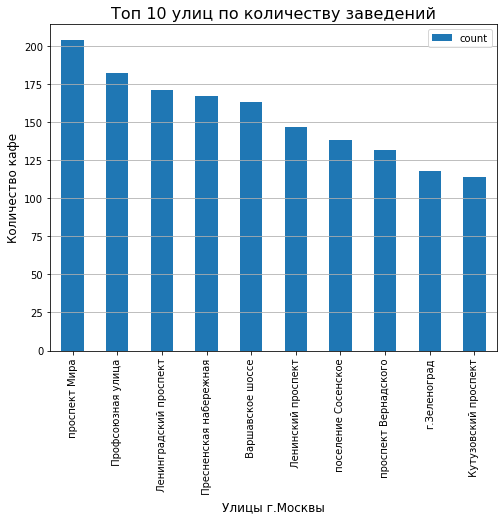

In [22]:
top_rests_by_streets.plot(kind='bar', figsize = (8,6))
plt.xlabel('Улицы г.Москвы',fontsize=12)
plt.ylabel('Количество кафе',fontsize=12)
plt.title('Топ 10 улиц по количеству заведений', fontsize=16)
plt.grid(True, axis='y')
plt.show()

---
Для того чтобы понять в каких районах находятся эти улицы, мне пришлось обратиться к внешним данным и определить районы города через геокодер. Для этого я и собирала адреса по группам.

---

In [23]:

dist = read_from_yandex_disk(dist_url)

def to_json(text):
    json_acceptable_string = str(text).replace('О\'', '').replace('\'', '\"').replace('True', 'true').replace('False', 'false')
    return json.loads(json_acceptable_string)


def district(position):  
    json = to_json(position)
    if len(json['context']) <= 2:  
        return "-"
    return json['context'][1]['text']

def point(position):
    json = to_json(position)
    return json['geometry']['coordinates']

dist['district'] = dist['position_info'].apply(district)
dist['point'] = dist['position_info'].apply(point)
dist.head()

,street,house_range,id,object_name,chain,object_type,address,number,number_category,position_info,district,point
0,1-й Автозаводский проезд,0,152594,Бар «Боливар»,нет,ресторан,"город Москва, 1-й Автозаводский проезд, дом 4,...",90,от 60 до 100,"{'id': 'address.1077664059788964', 'type': 'Fe...",округ Даниловский,"[37.6567244, 55.7048959]"
1,1-й Амбулаторный проезд,0,27410,Колледж Автомобильного транспорта № 9,нет,столовая,"город Москва, 1-й Амбулаторный проезд, дом 8, ...",100,от 60 до 100,"{'id': 'address.5762954602971530', 'type': 'Fe...",округ Аэропорт,"[37.533832, 55.8113855]"
2,1-й Балтийский переулок,0,22139,ХуанХэ,нет,ресторан,"город Москва, 1-й Балтийский переулок, дом 3/25",60,от 20 до 60,"{'id': 'address.4140740467379738', 'type': 'Fe...",округ Аэропорт,"[37.5186275, 55.8097823]"
3,1-й Басманный переулок,0,152133,Столовая института мировых цивилизаций,нет,столовая,"город Москва, 1-й Басманный переулок, дом 3, с...",50,от 20 до 60,"{'id': 'address.378301293935434', 'type': 'Fea...",округ Красносельский,"[37.6634556, 55.7709669]"
4,1-й Ботанический проезд,0,21527,Буфет при ГУП «Объединенный комбинат школьно п...,нет,столовая,"город Москва, 1-й Ботанический проезд, дом 2",40,от 20 до 60,"{'id': 'address.3092020135314484', 'type': 'Fe...",округ Свиблово,"[37.6341586, 55.8516538]"


In [24]:
dist = dist.reset_index()
dist = dist.drop(['id', 'index', 'object_name', 'chain', 'object_type', 'number', 'number_category', 'position_info'], axis=1)
dist.head()

,street,house_range,address,district,point
0,1-й Автозаводский проезд,0,"город Москва, 1-й Автозаводский проезд, дом 4,...",округ Даниловский,"[37.6567244, 55.7048959]"
1,1-й Амбулаторный проезд,0,"город Москва, 1-й Амбулаторный проезд, дом 8, ...",округ Аэропорт,"[37.533832, 55.8113855]"
2,1-й Балтийский переулок,0,"город Москва, 1-й Балтийский переулок, дом 3/25",округ Аэропорт,"[37.5186275, 55.8097823]"
3,1-й Басманный переулок,0,"город Москва, 1-й Басманный переулок, дом 3, с...",округ Красносельский,"[37.6634556, 55.7709669]"
4,1-й Ботанический проезд,0,"город Москва, 1-й Ботанический проезд, дом 2",округ Свиблово,"[37.6341586, 55.8516538]"


In [25]:
rest_data_dist = pd.merge(rest_data, dist,  how='right', on=['street','house_range'])
rest_data_dist = rest_data_dist.drop('address_y', axis=1).rename(columns = {'address_x': 'address'}, inplace = False)
rest_data_dist['street'] = rest_data_dist['street'].apply(lambda x: x.strip())
rest_data_dist.head()

,id,object_name,chain,object_type,address,number,number_category,street,house_range,district,point
0,152594,Бар «Боливар»,нет,ресторан,"город Москва, 1-й Автозаводский проезд, дом 4,...",90,от 60 до 100,1-й Автозаводский проезд,0,округ Даниловский,"[37.6567244, 55.7048959]"
1,184872,Пекарня,нет,кафетерий,"город Москва, 1-й Автозаводский проезд, дом 5",4,от 0 до 20,1-й Автозаводский проезд,0,округ Даниловский,"[37.6567244, 55.7048959]"
2,200076,Чайхана Элина,нет,кафе,"город Москва, 1-й Автозаводский проезд, дом 5",20,от 0 до 20,1-й Автозаводский проезд,0,округ Даниловский,"[37.6567244, 55.7048959]"
3,27410,Колледж Автомобильного транспорта № 9,нет,столовая,"город Москва, 1-й Амбулаторный проезд, дом 8, ...",100,от 60 до 100,1-й Амбулаторный проезд,0,округ Аэропорт,"[37.533832, 55.8113855]"
4,82610,Столовая театрального колледжа,нет,столовая,"город Москва, 1-й Амбулаторный проезд, дом 2, ...",40,от 20 до 60,1-й Амбулаторный проезд,0,округ Аэропорт,"[37.533832, 55.8113855]"


---
Теперь готова полная таблица со всей нужной мне информацией.

---

In [26]:
#1
mira_street = rest_data_dist[rest_data_dist['street'] == 'проспект Мира']
print('Улица: Проспект Мира:')
print(mira_street.groupby('district')['object_name'].count())

print()

#2
prof_street = rest_data_dist[rest_data_dist['street'] == 'Профсоюзная улица']
print('Улица: Профсоюзная:')
print(prof_street.groupby('district')['object_name'].count())

print()

#3 
len_street = rest_data_dist[rest_data_dist['street'] == 'Ленинградский проспект']
print('Улица: Ленинградский проспект:')
print(len_street.groupby('district')['object_name'].count())

print()

#4
presnya_street = rest_data_dist[rest_data_dist['street'] == 'Пресненская набережная']
print('Улица: Пресненская набережная:')
print(presnya_street.groupby('district')['object_name'].count())

print()

#5
varsh_street = rest_data_dist[rest_data_dist['street'] == 'Варшавское шоссе']
print('Улица: Варшавское шоссе:')
print(varsh_street.groupby('district')['object_name'].count())

print()

#6
lenin_street = rest_data_dist[rest_data_dist['street'] == 'Ленинский проспект']
print('Улица: Ленинский проспект:')
print(lenin_street.groupby('district')['object_name'].count())

print()

#8
vernadski_street = rest_data_dist[rest_data_dist['street'] == 'проспект Вернадского']
print('Улица: проспект Вернадского:')
print(vernadski_street.groupby('district')['object_name'].count())

print()

#10
kutuzov_street = rest_data_dist[rest_data_dist['street'] == 'Кутузовский проспект']
print('Улица: Кутузовский проспект:')
print(kutuzov_street.groupby('district')['object_name'].count())

Улица: Проспект Мира:
district
округ Алексеевский     62
округ Головинский       8
округ Мещанский       134
Name: object_name, dtype: int64

Улица: Профсоюзная:
district
Москва                  26
округ Замоскворечье     51
округ Коньково         100
округ Ясенево            6
Name: object_name, dtype: int64

Улица: Ленинградский проспект:
district
округ Аэропорт          54
округ Замоскворечье      2
округ Хорошевский      100
округ Южное Тушино      17
Name: object_name, dtype: int64

Улица: Пресненская набережная:
district
округ Пресненский    167
Name: object_name, dtype: int64

Улица: Варшавское шоссе:
district
округ Беговой                4
округ Чертаново Северное    62
округ Чертаново Южное       60
округ Южное Тушино          38
Name: object_name, dtype: int64

Улица: Ленинский проспект:
district
округ Ломоносовский    142
округ Южное Тушино       6
Name: object_name, dtype: int64

Улица: проспект Вернадского:
district
Москва                        59
округ Даниловский       

---
- В топ 10 улиц по количеству заведений вошли 2 района с особенными адресами: поселение Сосенское и г.Зеленоград. Я не стала удалять их из списка, так как они являются районами и их участие в списке обоснованное. 
- Так как некоторые улицы длинные и находятся в нескольких районах, я сгруппировала адреса расположенных на этих улицах заведений в небольшие таблицы и могу составить свой список их 10 самых популярных районов города:

    1) Мещанский
    
    2) Коньково
    
    3) Хорошевский
    
    4) Пресненский
    
    5) Чертаново Южное
    
    6) Ломоносовский
    
    7) Проспект Вернадского
    
    8) Дорогомилово
    
    9) поселение Сосенское
    
    10) г.Зеленоград
    
---

## Распределение заведений типов "кафе" и "предприятие быстрого обслуживания" по районам

In [27]:
cafe_by_streets = rest_data_dist[rest_data_dist['object_type'] == 'кафе']
cafe_by_streets = cafe_by_streets.groupby('street')['id'].count().to_frame().sort_values('id', ascending=False)
cafe_by_streets.columns = ['count']
cafe_by_streets.head()

,count
street,
проспект Мира,103
Пресненская набережная,98
поселение Сосенское,92
Профсоюзная улица,90
Ленинградский проспект,70


In [28]:
prof_street = rest_data_dist[rest_data_dist['street'] == 'Профсоюзная улица']
print('Улица: Профсоюзная:')
print(prof_street.groupby('district')['object_name'].count())

print()

lenslob_street = rest_data_dist[rest_data_dist['street'] == 'улица Ленинская Слобода']
print('Улица: Ленинская Слобода:')
print(lenslob_street.groupby('district')['object_name'].count())

print()

mira_street = rest_data_dist[rest_data_dist['street'] == 'проспект Мира']
print('Улица: Проспект Мира:')
print(mira_street.groupby('district')['object_name'].count())

print()

presnya_street = rest_data_dist[rest_data_dist['street'] == 'Пресненская набережная']
print('Улица: Пресненская набережная:')
print(presnya_street.groupby('district')['object_name'].count())

Улица: Профсоюзная:
district
Москва                  26
округ Замоскворечье     51
округ Коньково         100
округ Ясенево            6
Name: object_name, dtype: int64

Улица: Ленинская Слобода:
district
округ Даниловский    89
Name: object_name, dtype: int64

Улица: Проспект Мира:
district
округ Алексеевский     62
округ Головинский       8
округ Мещанский       134
Name: object_name, dtype: int64

Улица: Пресненская набережная:
district
округ Пресненский    167
Name: object_name, dtype: int64


In [29]:
fast_by_streets = rest_data_dist[rest_data_dist['object_type'] == 'предприятие быстрого обслуживания']
fast_by_streets = fast_by_streets.groupby('street')['id'].count().to_frame().sort_values('id', ascending=False)
fast_by_streets.columns = ['count']
fast_by_streets.head()

,count
street,
Кировоградская улица,47
Каширское шоссе,43
Варшавское шоссе,41
проспект Андропова,29
Ореховый бульвар,28


In [30]:
varsh_street = rest_data_dist[rest_data_dist['street'] == 'Варшавское шоссе']
print('Улица: Варшавское шоссе:')
print(varsh_street.groupby('district')['object_name'].count())

print()

crivogr_street = rest_data_dist[rest_data_dist['street'] == 'Кировоградская улица']
print('Улица: Кировоградская:')
print(crivogr_street.groupby('district')['object_name'].count())

print()

kashir_street = rest_data_dist[rest_data_dist['street'] == 'Каширское шоссе']
print('Улица: Каширское шоссе:')
print(kashir_street.groupby('district')['object_name'].count())

print()

andropov_street = rest_data_dist[rest_data_dist['street'] == 'проспект Андропова']
print('Улица: проспект Андропова:')
print(andropov_street.groupby('district')['object_name'].count())

print()

orehov_street = rest_data_dist[rest_data_dist['street'] == 'Ореховый бульвар']
print('Улица: Ореховый бульвар:')
print(orehov_street.groupby('district')['object_name'].count())

Улица: Варшавское шоссе:
district
округ Беговой                4
округ Чертаново Северное    62
округ Чертаново Южное       60
округ Южное Тушино          38
Name: object_name, dtype: int64

Улица: Кировоградская:
district
округ Беговой                    2
округ Чертаново Центральное    108
Name: object_name, dtype: int64

Улица: Каширское шоссе:
district
округ Беговой                 12
округ Замоскворечье           69
округ Москворечье-Сабурово     1
округ Пресненский              7
округ Тверской                21
округ Южное Тушино             2
Name: object_name, dtype: int64

Улица: проспект Андропова:
district
округ Беговой                 25
округ Москворечье-Сабурово    51
округ Нагатинский затон        3
Name: object_name, dtype: int64

Улица: Ореховый бульвар:
district
округ Зябликово       34
округ Марьина роща    41
Name: object_name, dtype: int64


---
- Я решила рассмотреть два типа заведений, характерных для несетевых общепитов - "кафе" и "предприятие быстрого обслуживания", взяла топ 5 улиц.
- Районы с наибольшим количеством заведений типа "кафе":

    1) поселение Сосенское
    
    2) Коньково
    
    3) Даниловский
    
    4) Мещанский
    
    5) Пресненский
    
- Районы с наибольшим количеством заведений типа "предприятие быстрого обслуживания":

    1) Чертаново Южное
    
    2) Чертаново Центральное
    
    3) Замоскворечье
    
    4) Москворечье-Сабурово
    
    5) Марьина роща
    
---

## Распределение количества посадочных мест по улицам

In [31]:
rests_by_streets.head()

,count
street,
проспект Мира,204
Профсоюзная улица,182
Ленинградский проспект,171
Пресненская набережная,167
Варшавское шоссе,163


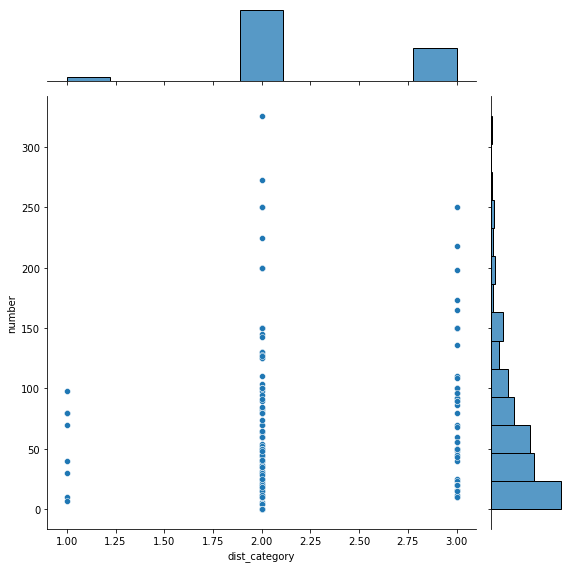

In [32]:
mira_number = rest_data_dist[rest_data_dist['street'] == 'проспект Мира'].copy()

def dist_category(row):
    if row['district'] == 'округ Головинский':
        return 1
    if row['district'] == 'округ Мещанский':
        return 2
    else:
        return 3
    
mira_number['dist_category'] = mira_number.apply(dist_category, axis = 1)

sns.jointplot(x='dist_category', y='number', data=mira_number, height=8) 

---
Среди заведений, расположенных на проспекте Мира, популярнее всего заведения, имеющие до 50 посадочных мест.

---

/var/folders/vx/vjxdxpfx19j6k3fggtp493v00000gq/T/ipykernel_13660/2675871843.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prof_number['dist_category'] = prof_number.apply(dist_category, axis = 1)


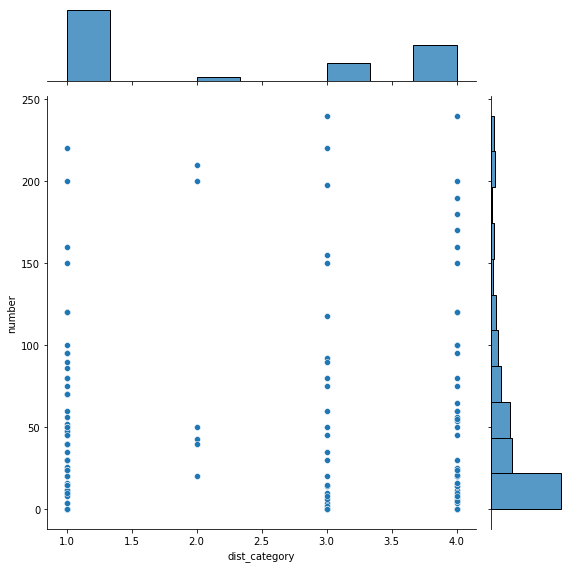

In [33]:
prof_number = rest_data_dist[rest_data_dist['street'] == 'Профсоюзная улица']

def dist_category(row):
    if row['district'] == 'округ Коньково':
        return 1
    if row['district'] == 'округ Ясенево':
        return 2
    if row['district'] == 'Москва':
        return 3
    else:
        return 4
    
prof_number['dist_category'] = prof_number.apply(dist_category, axis = 1)

sns.jointplot(x='dist_category', y='number', data=prof_number, height=8) 

---
Среди заведений, расположенных на улице Профсоюзной, популярнее всего заведения, имеющие до 30 посадочных мест.

---

/var/folders/vx/vjxdxpfx19j6k3fggtp493v00000gq/T/ipykernel_13660/1081816707.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  len_number['dist_category'] = len_number.apply(dist_category, axis = 1)


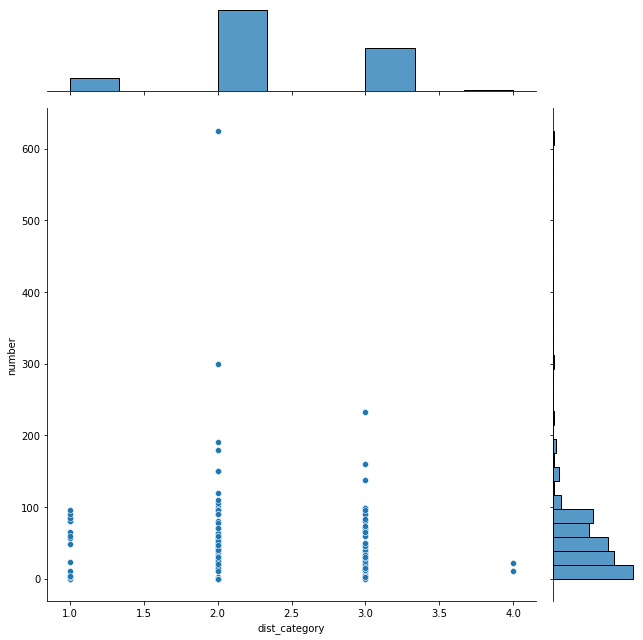

In [34]:
len_number = rest_data_dist[rest_data_dist['street'] == 'Ленинградский проспект']

def dist_category(row):
    if row['district'] == 'округ Южное Тушино':
        return 1
    if row['district'] == 'округ Хорошевский':
        return 2
    if row['district'] == 'округ Аэропорт':
        return 3
    else:
        return 4
    
len_number['dist_category'] = len_number.apply(dist_category, axis = 1)

sns.jointplot(x='dist_category', y='number', data=len_number, height=9) 

---
Среди заведений, расположенных на Ленинградством проспекте, популярнее всего заведения, имеющие до 100 посадочных мест.

---

/var/folders/vx/vjxdxpfx19j6k3fggtp493v00000gq/T/ipykernel_13660/192664119.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presnya_number['dist_category'] = presnya_number.apply(dist_category, axis = 1)


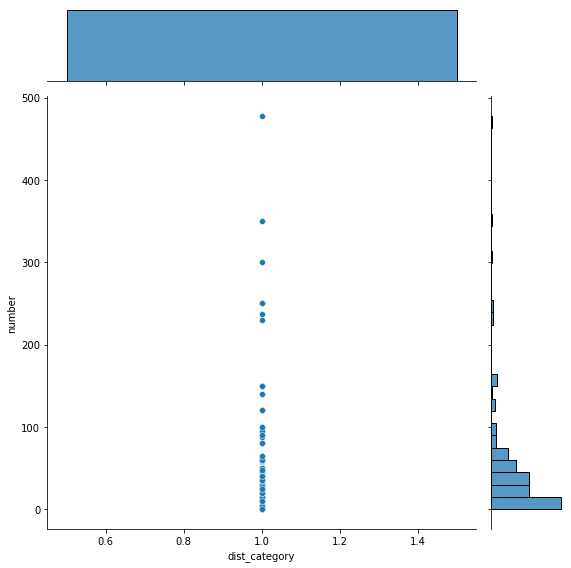

In [35]:
presnya_number = rest_data_dist[rest_data_dist['street'] == 'Пресненская набережная']

def dist_category(row):
    if row['district'] == 'округ Пресненский':
        return 1
    
presnya_number['dist_category'] = presnya_number.apply(dist_category, axis = 1)

sns.jointplot(x='dist_category', y='number', data=presnya_number, height=8) 

---
Среди заведений, расположенных на Пресненской набережной, популярнее всего заведения, имеющие до 80 посадочных мест.

---

/var/folders/vx/vjxdxpfx19j6k3fggtp493v00000gq/T/ipykernel_13660/3160645742.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  varsh_number['dist_category'] = varsh_number.apply(dist_category, axis = 1)


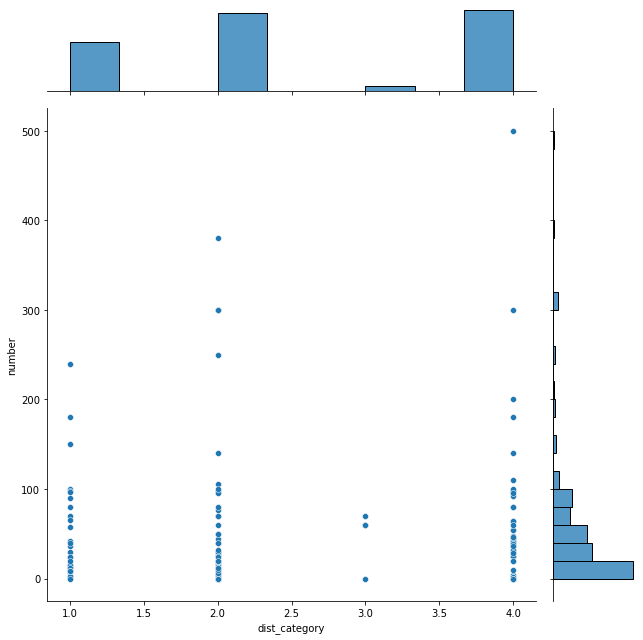

In [36]:
varsh_number = rest_data_dist[rest_data_dist['street'] == 'Варшавское шоссе']

def dist_category(row):
    if row['district'] == 'округ Южное Тушино':
        return 1
    if row['district'] == 'округ Чертаново Южное':
        return 2
    if row['district'] == 'округ Беговой':
        return 3
    else:
        return 4
    
varsh_number['dist_category'] = varsh_number.apply(dist_category, axis = 1)

sns.jointplot(x='dist_category', y='number', data=varsh_number, height=9) 

---
Среди заведений, расположенных на Варшавском шоссе, популярнее всего заведения, имеющие до 80 посадочных мест.

---

## Размещение объектов общественного питания на карте г.Москвы

In [37]:
def revers(arr):
    return list(reversed(arr))

rest_data_dist['point'] = rest_data_dist['point'].apply(revers)
rest_data_dist.head()

,id,object_name,chain,object_type,address,number,number_category,street,house_range,district,point
0,152594,Бар «Боливар»,нет,ресторан,"город Москва, 1-й Автозаводский проезд, дом 4,...",90,от 60 до 100,1-й Автозаводский проезд,0,округ Даниловский,"[55.7048959, 37.6567244]"
1,184872,Пекарня,нет,кафетерий,"город Москва, 1-й Автозаводский проезд, дом 5",4,от 0 до 20,1-й Автозаводский проезд,0,округ Даниловский,"[55.7048959, 37.6567244]"
2,200076,Чайхана Элина,нет,кафе,"город Москва, 1-й Автозаводский проезд, дом 5",20,от 0 до 20,1-й Автозаводский проезд,0,округ Даниловский,"[55.7048959, 37.6567244]"
3,27410,Колледж Автомобильного транспорта № 9,нет,столовая,"город Москва, 1-й Амбулаторный проезд, дом 8, ...",100,от 60 до 100,1-й Амбулаторный проезд,0,округ Аэропорт,"[55.8113855, 37.533832]"
4,82610,Столовая театрального колледжа,нет,столовая,"город Москва, 1-й Амбулаторный проезд, дом 2, ...",40,от 20 до 60,1-й Амбулаторный проезд,0,округ Аэропорт,"[55.8113855, 37.533832]"


---
- Я решила рассмотреть расположение заведений на карте города по районам. Для более наглядного примера я выбрала 3 типа заведений - "кафе", "ресторан", "предприятие быстрого обслуживания" и 4 района города, все они находятся на разном удалении от центра для определения специфики района.
- На картах заведения отмечены следующим образом:

    - "кафе" - зеленые метки
    
    - "ресторан" - голубые метки
    
    - "предприятие быстрого обслуживания" - красные метки
- Данные типы заведений были выбраны мной исходя из тематики планируемого заведения, а так же популярности типов несетевых общепитов.

---

In [38]:
for_map = rest_data_dist[rest_data_dist['district'] == 'округ Мещанский']
for_map_rest = for_map[for_map['object_type'] == 'ресторан']
for_map_cafe = for_map[for_map['object_type'] == 'кафе']
for_map_fast = for_map[for_map['object_type'] == 'предприятие быстрого обслуживания']

moscow = folium.Map(location = [55.786063, 37.635454], zoom_start = 10, min_zoom = 13, max_zoom = 16)

for point in for_map_cafe['point']:
    folium.Marker(point, icon=folium.Icon(color='green', icon='coffee', prefix='fa')).add_to(moscow)
for point in for_map_fast['point']:
    folium.Marker(point, icon=folium.Icon(color='red', icon='point', prefix='fa')).add_to(moscow)
for point in for_map_rest['point']:
    folium.Marker(point).add_to(moscow)

print('Карта округа Мещанский')
moscow


Карта округа Мещанский


---
- Район Мещанский можно считать одним из центральных районов Москвы. 
- Распределение типов заведений, я считаю, характерное для центральных районов. Большое количество ресторанов и кафе как бы "разбросаны" по карте. Это говорит нам о том, что в центре меньше больших фудкортов и каждое заведение имеет отдельное помещение. 
- Заведений с фастфудом(красные метки) мало и многие из них располагаются в торговых центрах(точки на карте, где метки накладываются друг на друга, значит заведения имеют один адрес)

---

In [39]:
for_map2 = rest_data_dist[rest_data_dist['district'] == 'округ Пресненский']
for_map2_rest = for_map2[for_map2['object_type'] == 'ресторан']
for_map2_cafe = for_map2[for_map2['object_type'] == 'кафе']
for_map2_fast = for_map2[for_map2['object_type'] == 'предприятие быстрого обслуживания']

moscow = folium.Map(location = [55.7526975, 37.5426013], zoom_start = 10, min_zoom = 13, max_zoom = 16)

for point in for_map2_cafe['point']:
    folium.Marker(point, icon=folium.Icon(color='green', icon='coffee', prefix='fa')).add_to(moscow)
for point in for_map2_fast['point']:
    folium.Marker(point, icon=folium.Icon(color='red', icon='point', prefix='fa')).add_to(moscow)
for point in for_map2_rest['point']:
    folium.Marker(point).add_to(moscow)

print('Карта округа Пресненский')
moscow

Карта округа Пресненский


---
- Пресненский район так же является центральным районом города Москвы.
- Типы заведений распределены так же, как в Мещанском районе. Преобладают кафе и рестораны, заведения быстрого питания тоже присутствуют, но не в таком количестве, и находятся в основном на общих площадях(фудкортах).

---

In [40]:
for_map3 = rest_data_dist[rest_data_dist['district'] == 'округ Коньково']
for_map3_rest = for_map3[for_map3['object_type'] == 'ресторан']
for_map3_cafe = for_map3[for_map3['object_type'] == 'кафе']
for_map3_fast = for_map3[for_map3['object_type'] == 'предприятие быстрого обслуживания']

moscow = folium.Map(location = [55.6505909, 37.5336561], zoom_start = 10, min_zoom = 13, max_zoom = 16)

for point in for_map3_cafe['point']:
    folium.Marker(point, icon=folium.Icon(color='green', icon='coffee', prefix='fa')).add_to(moscow)
for point in for_map3_fast['point']:
    folium.Marker(point, icon=folium.Icon(color='red', icon='point', prefix='fa')).add_to(moscow)
for point in for_map3_rest['point']:
    folium.Marker(point).add_to(moscow)

print('Карта округа Коньково')
moscow

Карта округа Коньково


---
- Район Коньково находится довольно далеко от центра.
- В этом районе мы можем заметить характерную смену распределения заведений. Почти все заведения в данном округе расположены, скорее всего, в торговых центрах и на общих фудкортах.

---

In [41]:
for_map4 = rest_data_dist[rest_data_dist['district'] == 'округ Чертаново Южное']
for_map4_rest = for_map4[for_map4['object_type'] == 'ресторан']
for_map4_cafe = for_map4[for_map4['object_type'] == 'кафе']
for_map4_fast = for_map4[for_map4['object_type'] == 'предприятие быстрого обслуживания']

moscow = folium.Map(location = [55.6009264, 37.6155572], zoom_start = 10, min_zoom = 13, max_zoom = 16)

for point in for_map4_cafe['point']:
    folium.Marker(point, icon=folium.Icon(color='green', icon='coffee', prefix='fa')).add_to(moscow)
for point in for_map4_fast['point']:
    folium.Marker(point, icon=folium.Icon(color='red', icon='point', prefix='fa')).add_to(moscow)
for point in for_map4_rest['point']:
    folium.Marker(point).add_to(moscow)

print('Карта округа Чертаново Южное')
moscow

Карта округа Чертаново Южное


---
- Район Южное Чертаново самый дальний от центра, из выбранных мной районов.
- Так же, как и на карте выше, можно наблюдать расположение большинства заведений на общих фудкортах и торговых центрах. 
- Количественно преобладают заведения быстрого обслуживания, кафе и рестораны в меньшинстве.

---

## Вывод

Поступил запрос на анализ рынка заведений общественного питания в городе Москва. Предполагается открытие заведения с роботизированной системой обслуживания. Проанализировав данные о заведениях города, я составила список рекомендаций, а так же прогноз дальнейшего развития заведения.

1) Рекомендуемый тип заведения это "предприятие быстрого обслуживания". На это есть несколько причин. 

    Первая, так как спецификой планируемого заведения является роботизированное обслуживание, наиболее успешно эту задумку можно реализовать в сфере быстрого питания. Примеры роботизации в кафе и ресторанах обычно имеют одни и те же выводы: интерес к заведению пропадает, старые клиенты в него не возвращаются, а новые клиенты заходят только ради интереса. В фастфуде же у роботизации на много больше возможностей и на много больше областей применения, а клиенты обычно возвращаются в подобные кафе еще не один раз, так как приходят туда за скоростью обслуживания и возможностью быстро перекусить или взять еду с собой.
    
    Вторая, у данного типа кафе будет довольно мало конкурентов среди несетевых заведений. В отличае от "кафе" и "ресторанов", каких внушительное большинство в г.Москва, заведению типа "предприятие быстрого обслуживания" будет куда развиваться. Есть возможность выделиться среди заведений того же типа и привлечь больше клиентов.
    
    Третья, есть возможность выбирать локацию от центра и до окраин города. Конечно, от локации будет зависеть дальнейший вектор развития заведения и его тематика, но это даже может сыграть на руку. В центральных районах города не так много подобных заведений, так что конкуренции бояться не стоит. Но придется сильно задуматься над концепцией и качеством обслуживания. Расположение ближе к окраинам города сможет обеспечить более крупные масштабы заведения, однако саму концепцию заведения и кухню можно делать попроще и понятнее, а так же дешевле.
    
2) Рекомендации по количеству посадочных мест так же разделяются на два варианта: 
    
    Первая, если распологать заведение ближе к центральной части Москвы, то количество посадочных мест в заведении не должно превышать 20-30 посадочных мест. Это обусловлено возможностями площадей в центре города. Маленькое количество мест не станет помехой для заведения быстрого питания, так как вся задумка данных заведений заключается в быстрой трапезе.
    
    Вторая, если заведение будет расположено в районе, расположенном дальше от центра, то уместно будет расчитывать на от 60 до 100 посадочных мест. Так как в отдаленных районах на много больше площадей, а жители отдаленных районов предпочитают в подобных заведениях проводить больше времени. 
    
3) Рекомендации по району расположения довольно простые. Расположение может зависеть от выбранного курса развития заведения. Среди центральных районов я бы посоветовала Мещанский и Пресненский, так как публика этого района может хорошо принять нововведения в обслуживании, а так же в данных районах довольно большая ежедневная проходимость, что создаст поток новых интересующихся посетителей. Среди отдаленных от центра районов я бы посоветовала Чертаново Южное и Коньково, так как публика в этих районах уже достаточно привыкла к заведениям подобного плана и готова к открытию для себя нового формата обслуживания. В этой локации стоит больше расчитывать на внимание постоянной аудитории и делать акцент на ее удержании.